## Example 1 - Common Drivers 

Here we investigate a proposed correlation between summer precipitation (JJA mean) in Denmark (DEN) and the Mediterranean (MED). A standard correlation test shows them to be negatively correlated, however this association is not causal but arises from the fact that both regions are affected by the position of the North Atlantic storm tracks, as for example described by the North Atlantic Oscillation (NAO) index.

<img src="../images/ex1.png" width="500" height="600">

### References / Notes

1. Mediterranean region as described in http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.368.3679&rep=rep1&type=pdf


## Imports

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import iris
import iris.quickplot as qplt

import statsmodels.api as sm
from scipy import signal

### Step 1) Load the data

In [20]:
precip = iris.load_cube('../sample_data/precip_jja.nc', 'Monthly Mean of Precipitation Rate')
nao = iris.load_cube('../sample_data/nao_jja.nc', 'nao')

### Step 2) Extract regions of interest

#### First region: Italy and the mediterranean 

In [21]:
med = precip.intersection(longitude=(10.0,30.0), latitude=(37.5, 45.0))

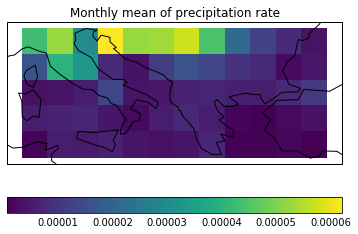

In [22]:
qplt.pcolormesh(med[0])
plt.gca().coastlines()

#### Second region: Denmark

In [23]:
den = precip.intersection(longitude=(1.71873247, 14.87022484), latitude=(50.02227492, 60.60017151))

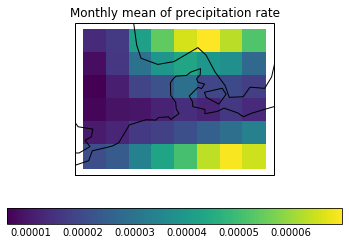

In [24]:
qplt.pcolormesh(den[0])
plt.gca().coastlines()

### Create regional means

In [25]:
def areal_mean(cube):
    grid_areas = iris.analysis.cartography.area_weights(cube)
    cube = cube.collapsed(['longitude', 'latitude'], iris.analysis.MEAN, weights=grid_areas)
    return cube

In [26]:
# Areal mean
med = areal_mean(med)
den = areal_mean(den)

/envs/auto-build-envs/datasci/lib/python3.6/site-packages/iris/analysis/cartography.py:394: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")
/envs/auto-build-envs/datasci/lib/python3.6/site-packages/iris/analysis/cartography.py:394: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")


#### Plot the data

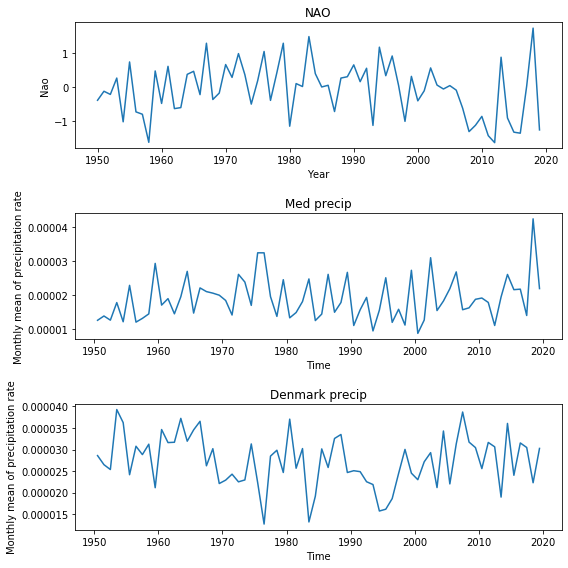

In [27]:
fig = plt.figure(figsize=(8, 8))

plt.subplot(311)
qplt.plot(nao)
plt.title('NAO')

plt.subplot(312)
qplt.plot(med)
plt.title('Med precip')

plt.subplot(313)
qplt.plot(den)
plt.title('Denmark precip')
plt.tight_layout()


### Step 3) Data analysis using regression

#### Standardize the data (zero mean, unit variance)

In [28]:
NAO = (nao - np.mean(nao.data))/np.std(nao.data)
MED = (med - np.mean(med.data))/np.std(med.data)
DEN = (den - np.mean(den.data))/np.std(den.data)

#### Detrend

In [29]:
NAO = signal.detrend(NAO.data)
MED = signal.detrend(MED.data)
DEN = signal.detrend(DEN.data)

#### Regression analysis

In [31]:
# Determine the effect from NAO --> MED
Y = MED
X =  NAO

model = sm.OLS(Y,X)
results = model.fit()

print("effect of NAO on MED  =", round(results.params[0],2))

effect of NAO on MED  = 0.46


In [32]:
# Determine the effect from NAO --> DEN
Y = DEN
X =  NAO

model = sm.OLS(Y,X)
results = model.fit()

print("effect of NAO on DEN  =", round(results.params[0],2))

effect of NAO on DEN  = -0.58


In [33]:
# Determine the effect from MED --> DEN
Y = DEN
X =  MED

model = sm.OLS(Y,X)
results = model.fit()

print("effect of MED on DEN  =", round(results.params[0],2))

effect of MED on DEN  = -0.23


In [34]:
# Modified effect if NAO is conditioned on

Y = DEN
X = np.stack([NAO, MED]).T

model = sm.OLS(Y,X)
results = model.fit()

print("effect of NAO on DEN =", round(results.params[0],2))

print("effect of MED on DEN =", round(results.params[1],2))

effect of NAO on DEN= -0.61
effect of MED on DEN = 0.05


#### Conclusions

When only considering the direct effect between MED and DEN we see a negative correlation which is spurious. If we include NAO in the regression analysis we control for the common effect bias and the direct correlation is shown to be negligible
